In [1]:
import numpy as np
from numpy.random import seed
import tensorflow as tf

from tensorflow import set_random_seed
seed(42)
set_random_seed(42)

from keras.layers import Input, Dense, TimeDistributed, Embedding
from keras.layers import Concatenate, Reshape, Lambda, Multiply, multiply, concatenate
from keras.models import Model
from keras import backend as K

import matplotlib.pyplot as plt
from matplotlib import style
from dataset_load import * 

style.use('seaborn-whitegrid')



# 'imdb-unigrams.txt'

X_train_original = open_pickle('../../data/imdb/imdb_original_preprocessed_xtrain.pickle')
X_test_original = open_pickle('../../data/imdb/imdb_original_preprocessed_xtest.pickle')
y_train_original = open_pickle('../../data/imdb/imdb_original_preprocessed_ytrain.pickle')
y_test_original = open_pickle('../../data/imdb/imdb_original_preprocessed_ytest.pickle')

# Count vectorizer 

from sklearn.feature_extraction.text import CountVectorizer

token = r"(?u)\b[\w\'/]+\b"
cv = CountVectorizer(min_df = 100, token_pattern=token, lowercase=True, binary=True)
X_train = cv.fit_transform(X_train_original)
X_test = cv.transform(X_test_original)

word_list, connotation = load_unigrams('./imdb-unigrams.txt', X_train_original, y_train_original)
# word_list, connotation = load_unigrams('./amazon-video-unigrams-more.txt', X_train_original, y_train_original)
# word_list, connotation = load_unigrams('./ecom-unigrams.txt', X_train_original, y_train_original)

y_train_agreement, y_test_agreement = generate_appearance(X_train_original, X_test_original, 
                                                          word_list, connotation)


def history_plot(history, model_name):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
        
    title = model_name + 'accuracy'
    plt.title(title)
    plt.xlabel('epoch')
    plt.legend(['tr_acc', 'val_acc'], loc='upper left')
    plt.show()
    plt.clf()

    plt.plot(history.history['loss'], 'm--')
    plt.plot(history.history['val_loss'], 'y--')

    title = model_name + 'loss'
    plt.title(title)
    plt.xlabel('epoch')
    plt.legend(['tr_loss', 'val_loss'], loc='upper left')
    plt.show()
    plt.clf()

Using TensorFlow backend.


### Test the custom loss

In [2]:
# # https://stackoverflow.com/questions/48951109/keras-custom-binary-cross-entropy-loss-function-get-nan-as-output-for-loss

# def custom_cross_entropy(y_true, y_pred):
#     t_loss = K.max(y_pred,0)-y_pred * y_true + K.log(1+K.exp((-1)*K.abs(y_pred)))
#     return K.mean(t_loss)

# from keras.initializers import Constant, glorot_uniform

# input_layer = Input(shape=(X_train.shape[1],))
# tanh_output = Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=42))(input_layer)
# model = Model(inputs=input_layer, outputs=tanh_output)

# model.compile(loss=custom_cross_entropy,
#              metrics=['acc'],
#              optimizer='adam')

# model.fit(X_train[:16667], y_train_original[:16667], 
#          validation_data=([X_train[16667:], y_train_original[16667:]]),
#          batch_size=1, epochs=1)

In [3]:
# model.evaluate(X_test, y_test_original)

In [4]:
# model.evaluate(X_train, y_train_original)

### 1st model

In [5]:
from keras.initializers import Constant, glorot_uniform

input_layer = Input(shape=(X_train.shape[1],))
tanh_output = Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=42))(input_layer)
model = Model(inputs=input_layer, outputs=tanh_output)

model.compile(loss='binary_crossentropy',
             metrics=['acc'],
             optimizer='adam')

base_history = model.fit(X_train[:16667], y_train_original[:16667], 
                 validation_data=([X_train[16667:], y_train_original[16667:]]),
                 batch_size=1, epochs=1)

Train on 16667 samples, validate on 8333 samples
Epoch 1/1
16667/16667 [==============================] - 43s 3ms/step - loss: 0.3437 - acc: 0.8615 - val_loss: 0.3015 - val_acc: 0.8766


In [6]:
model.evaluate(X_test, y_test_original)

25000/25000 [==============================] - 1s 60us/step


[0.28974985403060916, 0.88192]

In [7]:
model.evaluate(X_train, y_train_original)

25000/25000 [==============================] - 1s 59us/step


[0.24866909434318543, 0.90656]

In [8]:
model.trainable=True

### 2nd model

In [10]:
def layer_split(x):
    return tf.split(x,num_or_size_splits=human_terms_len,axis=1)

def layer_concat(x):
    return tf.concat(x, axis=1)

# build the combined model
# Combined model
human_terms_len = len(word_list)

# base_model = build_base_model(X_train.shape[1])

combined_input_layer = Input(shape=(X_train.shape[1],))

# build the hard coded weight for human terms
ht_input_layer = Input(shape=(human_terms_len,))

# split = Lambda( lambda x: tf.split(x,num_or_size_splits=human_terms_len,axis=1))(ht_input_layer)
split = Lambda(layer_split)(ht_input_layer)

# get the document prediction
label_layer = model(combined_input_layer)
# tanh_norm = Lambda(lambda x: (x*2)-1)(label_layer)
tanh_norm = Lambda(lambda x: tf.scalar_mul(2,x)-1)(label_layer)

# do normalize of bipolar sigmoid


# stack the multiply layer
dense_layer = []
for i in range(human_terms_len):
#     dense_layer.append(Dense(1, activation='relu', use_bias=False, kernel_initializer=='ones')(Multiply()([split[i], tanh_norm])))
    dense_layer.append(Lambda(lambda x: tf.nn.relu(x))(Multiply()([split[i], tanh_norm])))

# concat all the result   
# concat = Lambda( lambda x: tf.concat(x, axis=1), name='concatenate')(dense_layer)
concat = Lambda(layer_concat, name='concatenate')(dense_layer)


# pass it to sigmoid layer
output_layer = Dense(1, activation='sigmoid')(concat)

combined_model = Model(inputs=[combined_input_layer, ht_input_layer], outputs=output_layer)
# combined_model.summary()


combined_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['acc'])

# y_train_tanh = y_train_original
# y_train_tanh[y_train_tanh == 0] = -1

# y_test_tanh = y_test_original
# y_test_tanh[y_test_tanh == 0] = -1

# base_model_history = base_model.fit(X_train[:16667], y_train_original[:16667], 
#                                     validation_data=(X_train[16667:], y_train_original[16667:]),
#                                     batch_size=1, epochs=1)

combined_model_history = combined_model.fit([X_train[:16667],y_train_agreement[:16667]], y_train_original[:16667], 
                                            validation_data=([X_train[16667:], y_train_agreement[16667:]], y_train_original[16667:]),
                                            batch_size=1, epochs=1)

Train on 16667 samples, validate on 8333 samples
Epoch 1/1
16667/16667 [==============================] - 62s 4ms/step - loss: 0.3544 - acc: 0.8704 - val_loss: 0.3636 - val_acc: 0.8532


In [11]:
combined_model.evaluate([X_test, y_test_agreement], y_test_original)

25000/25000 [==============================] - 2s 76us/step


[0.35138445318222045, 0.85716]

In [12]:
combined_model.evaluate([X_train, y_train_agreement], y_train_original)

25000/25000 [==============================] - 2s 74us/step


[0.3023484233570099, 0.88084]

In [13]:
test_ev = combined_model.evaluate([X_test, y_test_agreement], y_test_original)
train_ev = combined_model.evaluate([X_train, y_train_agreement], y_train_original)

def accuracy_reject(combined_model, X, y_agreement, y):
    human_terms_relu_model = Model(inputs=combined_model.input,
                                    outputs=combined_model.get_layer('concatenate').output)
    predict_relu = human_terms_relu_model.predict([X, y_agreement])
    accept_indices = np.where(np.sum(predict_relu, axis=1)!=0)
    accept_indices = accept_indices[0]
    total_reject = X.shape[0] - len(accept_indices)
    rejection_rate = total_reject/X.shape[0]

    test_eval = combined_model.evaluate([X[accept_indices], y_agreement[accept_indices]], y[accept_indices])
    
    return test_eval, rejection_rate, total_reject

test_ev_reject = accuracy_reject(combined_model, X_test, y_test_agreement, y_test_original)
train_ev_reject = accuracy_reject(combined_model, X_train, y_train_agreement, y_train_original)

22128/22128 [==============================] - 2s 75us/step


In [14]:
print('%f \t %f' %(train_ev[0], train_ev[1]))
print('%f \t %f' %(test_ev[0], test_ev[1]))
print('%f \t %f \t %f \t %d' %(train_ev_reject[0][0], train_ev_reject[0][1], train_ev_reject[1], train_ev_reject[2]))
print('%f \t %f \t %f \t %d' %(test_ev_reject[0][0], test_ev_reject[0][1], test_ev_reject[1], test_ev_reject[2]))

0.302348 	 0.880840
0.351384 	 0.857160
0.252240 	 0.922587 	 0.114880 	 2872
0.306193 	 0.897864 	 0.118040 	 2951


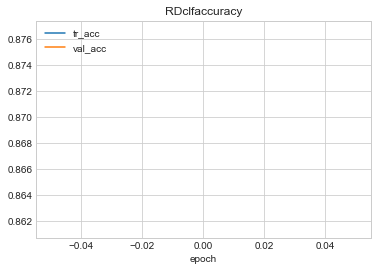

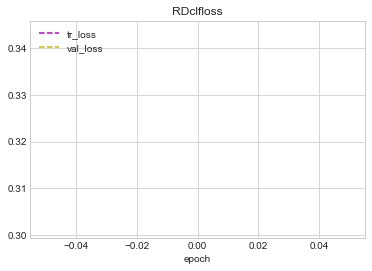

<Figure size 432x288 with 0 Axes>

In [15]:
history_plot(base_history,'RDclf')

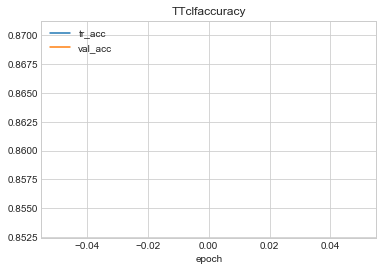

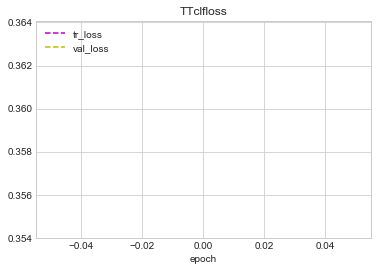

<Figure size 432x288 with 0 Axes>

In [16]:
history_plot(combined_model_history,'TTclf')

In [17]:
# model.save('./figure/stable-imdb-trainable-1-50/stable-imdb-trainable-1-50-base.h5')
# combined_model.save('./figure/stable-imdb-trainable-1-50/stable-imdb-trainable-1-50-combined.h5')

### Display

In [18]:
import re

class ColoredWeightedDoc(object):
    def __init__(self, doc, human_terms, ht_weights, token_pattern=r"(?u)\b\w\w+\b", binary = False):
        self.doc = doc
        self.human_terms = human_terms
        self.ht_weights = ht_weights
        self.binary = binary
        self.tokenizer = re.compile(token_pattern)
#         self.abs_ranges = np.linspace(0, max([abs(coefs.min()), abs(coefs.max())]), 8)
    def _repr_html_(self):
        html_rep = ""
        tokens = self.doc.split(" ") 
        if self.binary:
            seen_tokens = set()       
        for token in tokens:
            vocab_tokens = self.tokenizer.findall(token.lower())
            if len(vocab_tokens) > 0:
                vocab_token = vocab_tokens[0]
                try:
                    vocab_index = self.human_terms.index(vocab_token)
                    
                    if not self.binary or vocab_index not in seen_tokens:
                        
                        if self.ht_weights[vocab_index] == 0: # human-terms which has been washed out (opposing)
                            html_rep = html_rep + "<font size = 2, color=lightgreen> " + token + " </font>"
                        
                        elif self.ht_weights[vocab_index] != 0: # human-terms transparency
                            html_rep = html_rep + "<font size = 3, color=blue> " + token + " </font>"
                        
                        else: # neutral word
                            html_rep = html_rep + "<font size = 1, color=gainsboro> " + token + " </font>"
                        
                        if self.binary:    
                            seen_tokens.add(vocab_index)
                    
                    else: # if binary and this is a token we have seen before
                        html_rep = html_rep + "<font size = 1, color=gainsboro> " + token + " </font>"
                except: # this token does not exist in the vocabulary
                    html_rep = html_rep + "<font size = 1, color=gainsboro> " + token + " </font>"
            else:
                html_rep = html_rep + "<font size = 1, color=gainsboro> " + token + " </font>"
        return html_rep

In [19]:
review = list(['I was in Chicago last week. And I wanted to see a movie so bad. I am surprised that the movie itself is just amazing.  The plot was kinda weak, but it was great.  Christopher Nolan is just brilliant. Never fails to amaze. Even though the weather was terrible, but I enjoyed it. No regret! Overall, 10/10. Recommended.'])

review_cv = cv.transform(review)

In [20]:
y_t_review, _ = generate_appearance(review, review, word_list, connotation)

In [21]:
model.predict(review_cv)

array([[0.7587285]], dtype=float32)

In [22]:
combined_model.predict([review_cv, y_t_review])

array([[0.94382703]], dtype=float32)

In [55]:
from IPython import display


bm = model.predict(review_cv)
        
cm = combined_model.predict([review_cv, y_t_review])
        
layer_name = 'concatenate'
concat_after_relu = Model(inputs=combined_model.input,
                          outputs=combined_model.get_layer(layer_name).output)
concat_output = concat_after_relu.predict([review_cv, y_t_review])
        
print('actual label : ', 1, '\npredict from base model : ', bm.flatten(), '\npredict label : ', cm.flatten())
print()
for i,output in enumerate(concat_output.flatten()):
    if output != 0:
        print(word_list[i], output, w[2][i])


ht_weight = concat_output.flatten()
display.display(ColoredWeightedDoc(review[0], word_list, ht_weight, binary = False))

actual label :  1 
predict from base model :  [0.7587285] 
predict label :  [0.9647191]

10/10 0.517457 [1.146918]
amazing 0.517457 [1.1516336]
brilliant 0.517457 [0.3140431]
enjoyed 0.517457 [0.8944956]
great 0.517457 [1.7488922]
recommended 0.517457 [0.94111884]


In [30]:
connotation['recommended']

1

In [60]:
ht_weight

array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.517457, 0.517457, 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.517457, 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.517457,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.517457, 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.517457, 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      ], dtype=float32)

In [35]:
for i in range(len(word_list)):
    if word_list[i] == 'recommended':
        print(i)

62


In [37]:
y_t_review[0][62] = 1

In [53]:
w = combined_model.get_weights()

In [57]:
for i,ww in enumerate(w[2]):
    print(word_list[i], ww)

1/10 [-1.0807041]
2/10 [-0.85171443]
3/10 [-1.1229753]
4/10 [-1.0276376]
5/10 [0.47842273]
6/10 [0.06289372]
7/10 [1.1779239]
8/10 [0.9416599]
9/10 [0.6991757]
10/10 [1.146918]
amazing [1.1516336]
annoying [-0.7779559]
avoid [-0.97310996]
awful [-1.2838832]
bad [-1.7431507]
badly [-0.7795434]
beautiful [1.3726269]
beautifully [0.7501648]
best [1.4943271]
bland [-0.37973142]
boring [-1.365022]
brilliant [0.3140431]
cheap [-0.9712395]
disappointed [-0.71921706]
disappointing [-0.9985404]
disappointment [-0.9322827]
dreadful [-0.87605643]
dull [-0.89009094]
enjoyable [1.066103]
enjoyed [0.8944956]
excellent [1.5395813]
fails [-1.0614314]
fantastic [1.0914899]
fascinating [0.7456618]
favorite [1.0477363]
forgettable [-0.80262095]
fun [1.4407254]
funny [-1.0508761]
funniest [0.5873962]
gem [1.0194337]
great [1.7488922]
horrible [-1.0194359]
incredible [0.77599794]
insult [-0.9055235]
lacks [-0.74529386]
lame [-0.94240034]
laughable [-1.2936505]
lousy [-0.6958273]
loved [1.2099093]
mediocre 

In [59]:
len(w[0])

3686